# Resnets

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/resnets.ipynb)

In [ ]:
%pip install devinterp matplotlib seaborn torchvision

In [10]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim, nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from devinterp.slt import estimate_learning_coeff
from devinterp.optim.sgld import SGLD

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Transform to imagenet format
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.244, 0.225]),
    ]
)

trainset = datasets.CIFAR10(root="../data", train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root="../data", train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


/home/paperspace/devinterp/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/paperspace/devinterp/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 0.8934337016271086, Test Loss: 0.9743420645594597, Train Acc: 0.69704, Test Acc: 0.6636


Epoch 1:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 0.6596289170639855, Test Loss: 0.7990664541721344, Train Acc: 0.78394, Test Acc: 0.7316


Epoch 2:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 0.5150310155384394, Test Loss: 0.7075059518218041, Train Acc: 0.8389, Test Acc: 0.7643


Epoch 3:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 0.41121141171577025, Test Loss: 0.6588136121630669, Train Acc: 0.8828, Test Acc: 0.7867


Epoch 4:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 0.3293367821951302, Test Loss: 0.6345711693167686, Train Acc: 0.91532, Test Acc: 0.798


Epoch 5:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.32428682793159874, Test Loss: 0.666023463010788, Train Acc: 0.9222, Test Acc: 0.7934


Epoch 6:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 0.3025192328709729, Test Loss: 0.6659148469567299, Train Acc: 0.93114, Test Acc: 0.8008


Epoch 7:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 0.3999653691235854, Test Loss: 0.7317942917346955, Train Acc: 0.90612, Test Acc: 0.7852


Epoch 8:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 0.5043625086545944, Test Loss: 0.8003457069396973, Train Acc: 0.87284, Test Acc: 0.7685


Epoch 9:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 0.4767406116030654, Test Loss: 0.7688162192702294, Train Acc: 0.89396, Test Acc: 0.7856


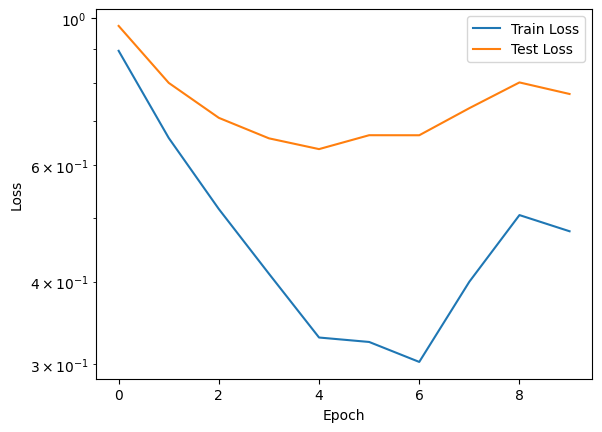

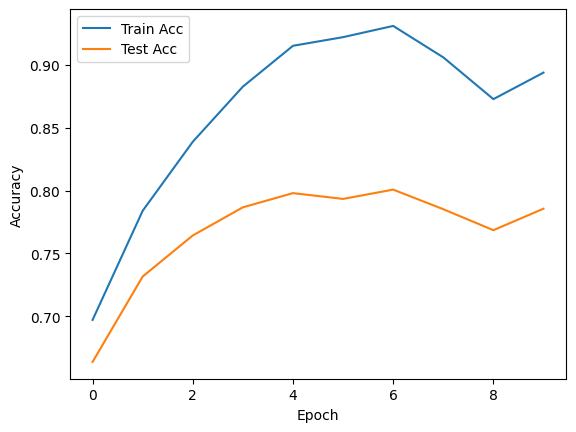

In [3]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)


def finetune(
    model,
    trainloader,
    testloader,
    lr=0.01,
    momentum=0.9,
    epochs=10,
    epsilon=1e-4,
    weight_decay=0.0,
):
    opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []

    epoch = 0
    prev_train_loss = float("inf")

    while True:
        # Train
        model.train()
        epoch_loss = 0.0
        for x, y in tqdm(trainloader, desc=f"Epoch {epoch}", leave=False):
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = loss_fn(model(x), y)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()

        # Eval on training set
        model.eval()
        with torch.no_grad():
            total_train_loss = 0
            total_train_correct = 0

            for x, y in trainloader:
                x, y = x.to(device), y.to(device)
                output = model(x)

                # print(x.shape, y.shape, output.shape, output, y)
                loss = loss_fn(output, y)
                total_train_loss += loss.item()
                total_train_correct += (
                    (output.max(dim=1).indices == y).sum().item()
                )  # argmax doesn't work on MPS

            avg_train_loss = total_train_loss / len(trainloader)
            avg_train_acc = total_train_correct / len(trainset)
            train_loss_history.append(avg_train_loss)
            train_acc_history.append(avg_train_acc)

            # Eval on test set
            total_test_loss = 0
            total_test_correct = 0

            for x, y in testloader:
                x, y = x.to(device), y.to(device)
                output = model(x)
                loss = loss_fn(output, y)
                total_test_loss += loss.item()
                total_test_correct += (output.max(dim=1).indices == y).sum().item()

            avg_test_loss = total_test_loss / len(testloader)
            avg_test_acc = total_test_correct / len(testset)
            test_loss_history.append(avg_test_loss)
            test_acc_history.append(avg_test_acc)

            print(
                f"Epoch: {epoch}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}, Train Acc: {avg_train_acc}, Test Acc: {avg_test_acc}"
            )

        # Check for convergence
        if epsilon and abs(prev_train_loss - avg_train_loss) < epsilon:
            break

        if epochs is not None and epoch >= epochs - 1:
            break

        prev_train_loss = avg_train_loss
        epoch += 1

    # Plotting
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(test_loss_history, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()

    plt.plot(train_acc_history, label="Train Acc")
    plt.plot(test_acc_history, label="Test Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


finetune(model, trainloader, testloader, lr=0.001, weight_decay=0.1, epsilon=0.001)

In [4]:
for i in range(10):
    rlct = estimate_learning_coeff(
        model,
        trainloader,
        nn.CrossEntropyLoss(),
        num_draws=10,
        num_chains=5,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        cores=None,
        seed=None,
        pbar=True,
        device="cpu",
    )
    print(f"Estimate {i}:", rlct)

Chain 4: 100%|██████████| 10/10 [01:16<00:00,  7.65s/it]


Estimate 0: 168.9925465558584


Chain 4: 100%|██████████| 10/10 [01:13<00:00,  7.38s/it]


Estimate 1: -128.23227039434528


Chain 4: 100%|██████████| 10/10 [01:12<00:00,  7.20s/it]


Estimate 2: -149.63625766715893


Chain 4: 100%|██████████| 10/10 [01:12<00:00,  7.25s/it]


Estimate 3: -134.72011001113017


Chain 4: 100%|██████████| 10/10 [01:15<00:00,  7.54s/it]


Estimate 4: -86.63054339836026


Chain 4: 100%|██████████| 10/10 [01:11<00:00,  7.19s/it]


Estimate 5: -174.31443593456046


Chain 4: 100%|██████████| 10/10 [01:15<00:00,  7.52s/it]


Estimate 6: 90.19326094017036


Chain 4: 100%|██████████| 10/10 [01:17<00:00,  7.70s/it]


Estimate 7: 175.768637276861


Chain 4: 100%|██████████| 10/10 [01:15<00:00,  7.56s/it]


Estimate 8: -185.3341943931179


Chain 4: 100%|██████████| 10/10 [01:13<00:00,  7.36s/it]


Estimate 9: -4.93717813430555


-------------------- ResNet18 --------------------


Epoch 0:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 0.6449124283936559, Test Loss: 0.7559548437595367, Train Acc: 0.77768, Test Acc: 0.7437


Epoch 1:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 0.4031578442271875, Test Loss: 0.6182190537452698, Train Acc: 0.86786, Test Acc: 0.7925


Epoch 2:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 0.3279452522342302, Test Loss: 0.6600558072328567, Train Acc: 0.88614, Test Acc: 0.7881


Epoch 3:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 0.2007149958184787, Test Loss: 0.6325093723833561, Train Acc: 0.93584, Test Acc: 0.809


Epoch 4:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 0.17263439537159034, Test Loss: 0.7287720218300819, Train Acc: 0.94178, Test Acc: 0.8012


Epoch 5:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.10977984845106091, Test Loss: 0.7102049320936203, Train Acc: 0.96424, Test Acc: 0.8082


Epoch 6:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 0.11857757614735438, Test Loss: 0.8230372041463851, Train Acc: 0.95912, Test Acc: 0.7984


Epoch 7:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 0.0814385289060218, Test Loss: 0.8667522475123406, Train Acc: 0.97246, Test Acc: 0.804


Epoch 8:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 0.07100221375003457, Test Loss: 0.8322690680623055, Train Acc: 0.97646, Test Acc: 0.806


Epoch 9:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 0.07805242602314268, Test Loss: 0.890138940513134, Train Acc: 0.9735, Test Acc: 0.8007


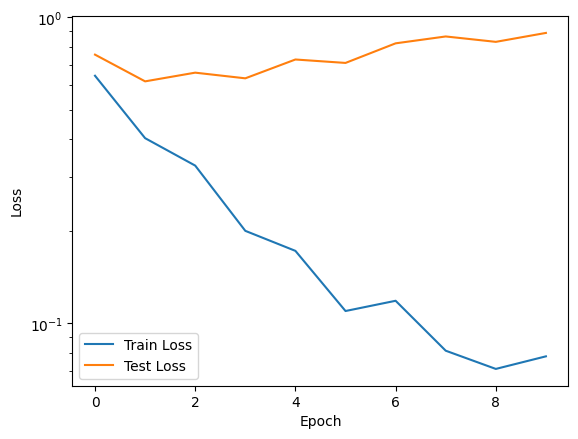

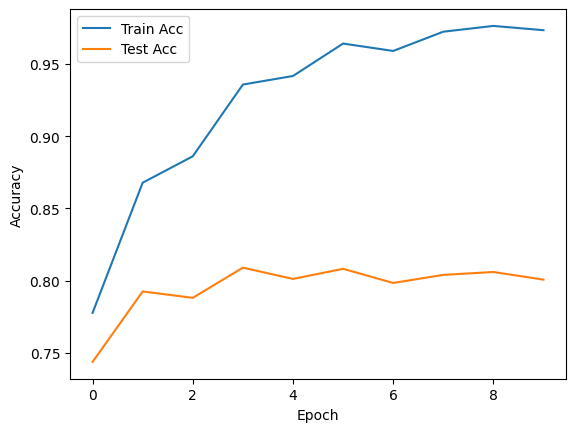

Chain 2: 100%|██████████| 100/100 [19:56<00:00, 11.96s/it]


156.9145085296802


Chain 2: 100%|██████████| 100/100 [20:33<00:00, 12.33s/it]


25.892749934175924


Chain 2: 100%|██████████| 100/100 [24:44<00:00, 14.85s/it]


-36.41833667218514
-------------------- ResNet34 --------------------


/home/paperspace/devinterp/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/paperspace/devinterp/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/paperspace/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 65.3MB/s]


Epoch 0:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 0.5923463446753365, Test Loss: 0.69865732640028, Train Acc: 0.7974, Test Acc: 0.7555


Epoch 1:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 0.3793479237629443, Test Loss: 0.5900914400815964, Train Acc: 0.87462, Test Acc: 0.7975


Epoch 2:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 0.2862974471431606, Test Loss: 0.6101823449134827, Train Acc: 0.90464, Test Acc: 0.7982


Epoch 3:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 0.18697238816138434, Test Loss: 0.6153422854840755, Train Acc: 0.93738, Test Acc: 0.8108


Epoch 4:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 0.14856609846560323, Test Loss: 0.6892005704343319, Train Acc: 0.95036, Test Acc: 0.8031


Epoch 5:   0%|          | 0/196 [00:00<?, ?it/s]

In [15]:
rlcts = []
resnet_depths = [18, 34, 50, 101, 152]

for num_layers in resnet_depths:
    print("-" * 20 + f" ResNet{num_layers} " + "-" * 20)
    model_name = f"resnet{num_layers}"
    model = getattr(torchvision.models, model_name)(pretrained=True).to(device)
    checkpoint_folder = f"../checkpoints/resnet-finetuned-cifar/"
    checkpoint_full_path = checkpoint_folder + f"{model_name}.pt"

    if os.path.exists(checkpoint_full_path):
        print("Loading from checkpoint")
        model.load_state_dict(torch.load(checkpoint_full_path))
    else:
        finetune(model, trainloader=trainloader, testloader=testloader)
        if not os.path.exists(checkpoint_folder):
            os.makedirs(checkpoint_folder)
        torch.save(model.state_dict(), checkpoint_full_path)

    _rlcts = []

    for i in range(3):
        _rlct = estimate_learning_coeff(
            model,
            trainloader,
            nn.CrossEntropyLoss(),
            sampling_method=SGLD,
            num_draws=100,
            num_chains=3,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            optimizer_kwargs={"elasticity": 100},
            cores=None,
            seed=None,
            pbar=True,
            device="cpu",
        )
        _rlcts.append(_rlct)
        print(_rlct)

    rlcts.append(_rlcts)

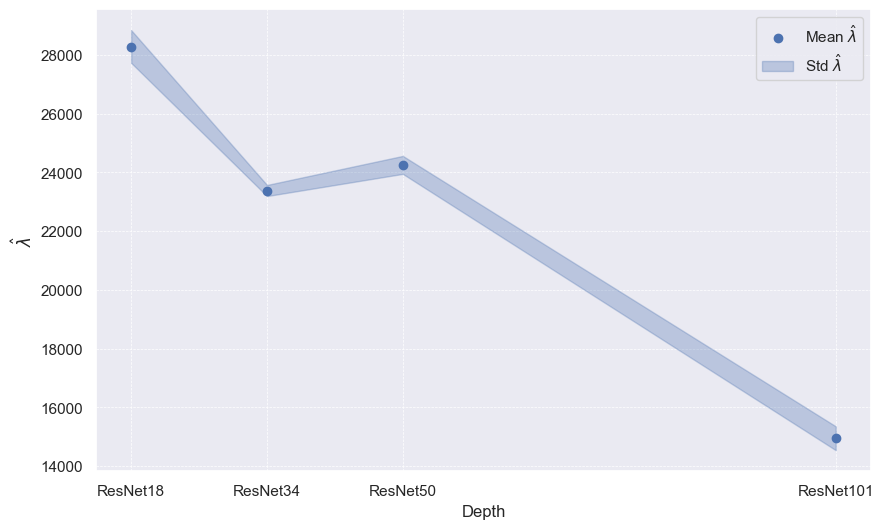

: 

In [ ]:
sns.set()

blue = sns.color_palette()[0]

resnet_depths = [18, 34, 50, 101]

# Names for the different ResNet architectures
arch_names = ["ResNet18", "ResNet34", "ResNet50", "ResNet101"]  # , "ResNet152"]

# Calculate means and standard deviations
means = [np.mean(_rlcts) for _rlcts in rlcts]
stds = [np.std(_rlcts) for _rlcts in rlcts]

# Calculate error bounds
lower_bounds = [mean - std for mean, std in zip(means, stds)]
upper_bounds = [mean + std for mean, std in zip(means, stds)]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the scatter points for the means
plt.scatter(resnet_depths, means, color=blue, label=r"Mean $\hat\lambda$", zorder=2)

# Plot the transparent area chart for the error bars
plt.fill_between(
    resnet_depths,
    lower_bounds,
    upper_bounds,
    color=blue,
    alpha=0.3,
    label=r"Std $\hat\lambda$",
)

# Annotate and style the plot
plt.xlabel("Depth")
plt.ylabel(r"$\hat\lambda$")
plt.xticks(resnet_depths, arch_names)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()

# Show the plot
plt.show()